In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

2023-06-28 14:07:37.995369: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:07:42.775768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 14:07:42.777898: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 14:07:53.382563: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.12.0


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import sqlite3
import pandas as pd
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from datetime import datetime
import random

In [3]:
import os
os.chdir('/gstore/project/hr_brca_heterogeneity/T47D_trace_Seq_v2/Nathan')
#os.listdir()

In [4]:
'''Hyperparameters'''

batch_size = 32 # was 32
seq_len = 8 # was 128

#d_k = 256
#d_v = 256
n_heads = 40 # was 60  # Number of attention heads # no difference or imporvement between 5-60
n_head_size= 5 # was 46 # Embedding size for attention # no difference between 5-46
n_ff_dim = 5  # was 55    # Hidden layer size in feed forward network inside transformer # some difference between 5-55


In [5]:
#### full data
import json

# f = open('tran_9545_barcodes2.json') is 25% cells have count of 3 or more (RT-PT)
# f = open('tran_9545_barcodes3.json') is 10% cells have count of 1 or more (RT-PT)
# f = open('tran_9545_barcodes4.json') is PTIME ONLY order with 10% cells have count of 1 or more
# f = open('tran_9545_barcodes5.json') is PTIME ONLY order AND P-SURV with 10% cells have count of 1 or more
# f = open('tran_9545_barcodes6.json') is PLSR PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_9545_barcodes8.json') is PLSR BREASTcgp + ESRcgp Paths PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_9545_barcodes9.json') is PLSR PID + HALLMARK Paths PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_Palbo_barcodes.json') is palbo PLSR genes PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
# f = open('tran_Palbo_barcodes.json') is combo PLSR genes PTIME ONLY order AND P-SURV with 10% cells have count of 3 or more
f = open('tran_9545_barcodes2.json')
data = json.load(f)

In [6]:
exp_days = {'Day 0': 1, 'Day 1': 2, 'Day 4': 3, 'Day 8': 4, 'Day 26': 5}

df = pd.DataFrame(data['GFPBC_libB_90850'])
df.iloc[:, 0:len(df.columns)-1]

,Pseudotime,RealTime,Survival,HES4,AURKAIP1,MRPL20,SSU72,RER1,RPL22,PLEKHG5,...,ALG13,SLC25A5,NDUFA1,SMARCA1,SAGE1,HMGB3,BCAP31,SSR4,RPL10,LAGE3
0,2.8499,1,0.0000,3.2787,3.6561,3.0451,2.6036,2.7662,1.9641,0.0000,...,1.6673,3.1666,3.0451,0.7869,5.1916,2.2101,0.0000,3.1666,3.0451,1.6673
1,3.8780,1,0.0000,2.5437,3.6173,2.5437,2.8955,2.3293,0.8521,0.0000,...,1.3842,3.6173,0.8521,2.0774,5.0534,2.5437,1.7721,3.1782,2.5437,2.3293
2,4.4359,1,0.0000,2.7329,3.2437,1.9351,2.7329,1.9351,1.9351,0.0000,...,0.0000,3.0926,2.7329,2.2526,5.1246,1.5274,0.9570,3.7265,3.8256,0.0000
3,4.4658,1,0.0000,3.0600,3.0600,2.0916,3.0600,2.0916,2.0916,1.3956,...,2.3441,2.9115,3.0600,0.8604,4.8848,0.8604,2.0916,3.1946,2.7460,2.5590
4,4.9656,1,0.0000,2.7702,3.2829,1.5561,2.5488,2.5488,1.5561,0.9784,...,1.9675,3.4200,3.2829,2.2873,5.6853,1.9675,2.5488,3.1314,2.5488,1.5561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,55.1317,5,2.1368,2.3201,2.8054,1.5834,2.3201,0.0000,0.9988,2.3201,...,2.3201,1.9983,1.9983,0.9988,6.6559,0.0000,1.5834,2.9980,1.9983,0.9988
2426,55.1317,5,2.1368,1.6725,1.9426,1.7683,2.0225,1.0662,1.4595,2.4840,...,2.5393,1.6725,1.0662,1.3399,5.6936,0.0000,1.0662,2.1701,1.8581,1.0662
2427,55.1317,5,2.1368,1.8365,1.4406,1.8365,1.8365,1.8365,1.8365,3.3825,...,2.6189,0.0000,1.4406,2.8074,6.1204,2.1468,0.8931,3.1234,0.0000,0.0000
2428,55.1317,5,2.1368,1.4170,1.9499,2.0364,1.4170,1.1330,0.9668,2.5292,...,3.4623,2.0364,1.1330,2.5292,6.0579,1.2820,1.2820,2.7500,2.0364,0.9668


In [7]:
barcodes = [i for i in data.keys()]
new_barcodes = []
for i in barcodes:
    df = pd.DataFrame(data[i])
    #print(i, df.shape[0])
    if df.shape[0] > 400: # 50 or 60
        new_barcodes.append(i)
print(new_barcodes)

bar_dict = {new_barcodes[i]:i for i in range(len(new_barcodes))}

['GFPBC_libB_20182', 'GFPBC_libB_83026', 'GFPBC_libB_92196', 'GFPBC_libB_94397', 'GFPBC_libB_40758', 'GFPBC_libB_90850', 'GFPBC_libB_10678', 'GFPBC_libB_37798', 'GFPBC_libB_31581']


In [8]:
'''Create training and test data'''

def transformer_train_test_split_dayiter(bar, frac_val, extra_var_bool, splitval):
    
    bardf = pd.DataFrame(data[bar])
    #bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf['RealTime'].tolist())
    snum = int(num_cell_day*splitval)
    bardf = bardf.iloc[:snum,:]
    
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2['RealTime'].tolist())
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
    #bardf2 = bardf2.dropna()
    COLS = bardf2.columns.tolist()[1:]
    #print(COLS)
    
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    #print(bardf_val)
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    
    # Training data
    X_train, y_train = [], []
    for i in range(seq_len, len(train_data)):
      X_train.append(train_data[i-seq_len:i]) 
      y_train.append(train_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Validation data
    X_val, y_val = [], []
    for i in range(seq_len, len(val_data)):
      X_val.append(val_data[i-seq_len:i]) 
      y_val.append(val_y[i]) #Value of 0th column (Survival) of df-row seq_len+1
    X_val, y_val = np.array(X_val), np.array(y_val)
    
    print('Transformer Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val, COLS

In [9]:
'''Create training and test data'''

def regr_train_test_split_dayiter(bar, frac_val, extra_var_bool, splitval):
    
    bardf = pd.DataFrame(data[bar])
    #bardf = bardf[bardf['RealTime'] <= exp_days[d]]
    num_cell_day = len(bardf['RealTime'].tolist())
    snum = int(num_cell_day*splitval)
    bardf = bardf.iloc[:snum,:]
    
    bardf = bardf.iloc[:,:len(bardf.columns)-1]
    bardf['RealTime'] = bardf['RealTime'].astype('category')
    bardf['Barcode'] = [bar_dict[bar] for _ in range(bardf.shape[0])]
    bardf['Barcode'] = bardf['Barcode'].astype('category')
    
    # normalize after train/test split
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    bardf2 = pd.DataFrame(scaler.fit_transform(bardf.iloc[:,2:len(bardf.columns)-1])) # survival and expression
    bardf2.columns = bardf.columns[2:len(bardf.columns)-1]
    
    if extra_var_bool[0]:
        bardf2['RealTime'] = bardf['RealTime'].astype('category')
        num_cell_day = len(bardf2['RealTime'].tolist())
    if extra_var_bool[1]:
        bardf2['Barcode'] = bardf['Barcode'].astype('category')
    if extra_var_bool[2]:
        bardf2['Pseudotime'] = bardf['Pseudotime']
        
    bardf2 = bardf2.dropna()
    bardf2.index = [i for i in range(bardf2.shape[0])]
    bardf_train = bardf2[:-(round(num_cell_day*frac_val))]
    bardf_val = bardf2[len(bardf2) - (round(num_cell_day*frac_val)):]
    #print(bardf_val)
    
    train_y = bardf_train['Survival']
    train_data = bardf_train.iloc[:,1:]
    val_y = bardf_val['Survival'].tolist()
    val_data = bardf_val.iloc[:,1:]
    
    # Training data
    X_train, y_train = np.array(train_data), np.array(train_y)
    
    # Validation data
    X_val, y_val = np.array(val_data), np.array(val_y)
    
    print('Regr Training/Val set shapes (varies depending on barcode) ', X_train.shape, X_val.shape)
    return X_train, y_train, X_val, y_val

In [10]:
########### testing function #################
# make the training and validation data

b = 'GFPBC_libB_92196'
frac_val = 0.20
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime
vs = [0.25, 0.5, 0.75, 1]
pct_test = frac_val/len(vs)
for v in vs:
    X_train, y_train, X_val, y_val, cols = transformer_train_test_split_dayiter(b, pct_test, extra_var_bool, v)
    X_train, y_train, X_val, y_val = regr_train_test_split_dayiter(b, pct_test, extra_var_bool, v)


Transformer Training/Val set shapes (varies depending on barcode)  (693, 8, 1139) (167, 8, 1139)
Regr Training/Val set shapes (varies depending on barcode)  (701, 1139) (175, 1139)
Transformer Training/Val set shapes (varies depending on barcode)  (1569, 8, 1139) (167, 8, 1139)
Regr Training/Val set shapes (varies depending on barcode)  (1577, 1139) (175, 1139)
Transformer Training/Val set shapes (varies depending on barcode)  (2445, 8, 1139) (167, 8, 1139)
Regr Training/Val set shapes (varies depending on barcode)  (2453, 1139) (175, 1139)
Transformer Training/Val set shapes (varies depending on barcode)  (3321, 8, 1139) (167, 8, 1139)
Regr Training/Val set shapes (varies depending on barcode)  (3329, 1139) (175, 1139)


In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, num_transformer_blocks, dropout=0):
    
    for _ in range(num_transformer_blocks):
        # Normalization and Attention
        # "EMBEDDING LAYER"
        x = layers.LayerNormalization(epsilon=1e-6)(inputs)

        # "ATTENTION LAYER"
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        x = layers.Dropout(dropout)(x)
        res = x + inputs
    
    for _ in range(num_transformer_blocks):
        # FEED FORWARD Part - you can stick anything here or just delete the whole section - it will still work. 
        x = layers.LayerNormalization(epsilon=1e-6)(res)
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation = "relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0, 
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # This is what stacks our transformer blocks
    x = transformer_encoder(x, head_size, num_heads, ff_dim, num_transformer_blocks, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="elu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="linear")(x) #this is a pass-through
    return keras.Model(inputs, outputs)

In [13]:
def lr_scheduler(epoch, lr, warmup_epochs=30, decay_epochs=100, initial_lr=1e-6, base_lr=1e-3, min_lr=5e-5):
    if epoch <= warmup_epochs:
        pct = epoch / warmup_epochs
        return ((base_lr - initial_lr) * pct) + initial_lr

    if epoch > warmup_epochs and epoch < warmup_epochs+decay_epochs:
        pct = 1 - ((epoch - warmup_epochs) / decay_epochs)
        return ((base_lr - min_lr) * pct) + min_lr

    return min_lr

# This learning rate scheduler is also from Mr. Theodoros Ntakouris' articla at https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
# I am definetely a fan.

In [14]:
callbacks = [
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.LearningRateScheduler(lr_scheduler)
            ]

In [15]:
from keras.utils.vis_utils import plot_model
import pydot
import graphviz

#tf.keras.utils.plot_model(model, to_file ='model_plot.png', show_shapes = True, show_layer_names = True)

In [16]:
def SHAPvals(X_val, y_val, bar, COLS, dir_path):
    
    #COLS = bardf.columns.tolist()[1:] # may need fixing
    #print(len(COLS), X_val.shape)
    #print(COLS)

    results = []
    print(' Computing feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = model.predict(X_val, verbose=0).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y_val ))
    results.append({'feature':'BASELINE','mae':baseline_mae})           

    for k in range(len(COLS)):

        if k in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
            print('SHAP', k)
        # SHUFFLE FEATURE K
        save_col = X_val[:,:,k].copy()
        np.random.shuffle(X_val[:,:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = model.predict(X_val, verbose=0).squeeze() 
        mae = np.mean(np.abs( oof_preds-y_val ))
        results.append({'feature':COLS[k],'mae':mae})
        X_val[:,:,k] = save_col

    # DISPLAY FEATURE IMPORTANCE
    print()
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(len(COLS)+1),df.mae)
    plt.yticks(np.arange(len(COLS)+1),df.feature.values)
    plt.title('Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
             label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
    plt.xlabel(f'OOF MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    # SAVE FEATURE IMPORTANCE
    df = df.sort_values('mae',ascending=False)
    df['fc_mae'] = df['mae'] - baseline_mae
    df.to_csv(dir_path+bar+'_feature_importance.csv',index=False)

In [17]:
def regr_SHAPvals(X_val, y_val, bar, COLS, dir_path):
    
    #COLS = bardf.columns.tolist()[1:] # may need fixing
    #print(len(COLS), X_val.shape)
    #print(COLS)

    results = []
    print(' Computing feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    oof_preds = regr.predict(X_val).squeeze() 
    baseline_mae = np.mean(np.abs( oof_preds-y_val ))
    results.append({'feature':'BASELINE','mae':baseline_mae})           

    for k in range(len(COLS)):

        if k in [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
            print('SHAP', k)
        # SHUFFLE FEATURE K
        save_col = X_val[:,k].copy()
        np.random.shuffle(X_val[:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        oof_preds = regr.predict(X_val).squeeze() 
        mae = np.mean(np.abs( oof_preds-y_val ))
        results.append({'feature':COLS[k],'mae':mae})
        X_val[:,k] = save_col

    # DISPLAY FEATURE IMPORTANCE
    print()
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(len(COLS)+1),df.mae)
    plt.yticks(np.arange(len(COLS)+1),df.feature.values)
    plt.title('Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(COLS)+1], '--', color='orange',
             label=f'Baseline OOF\nMAE={baseline_mae:.3f}')
    plt.xlabel(f'OOF MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

    # SAVE FEATURE IMPORTANCE
    df = df.sort_values('mae',ascending=False)
    df['fc_mae'] = df['mae'] - baseline_mae
    df.to_csv(dir_path+bar+'_feature_importance.csv',index=False)

In [18]:
def plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, dir_path):
    
    #Calculate predication for training, validation and test data
    print(X_train.shape, X_val.shape)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)

    #Print evaluation metrics for all datasets
    train_mse = mean_squared_error(y_train, train_pred)
    val_mse = mean_squared_error(y_val, val_pred)
    print(' ')
    print('Transformer Evaluation metrics')
    print('Transformer Training MSE - MSE: {:.4f}'.format(train_mse)) ### these lines should be MSE???
    print('Transformer Validation MSE - MSE: {:.4f}'.format(val_mse))
    

    plt.plot(y_train, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title("Transformer Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_val, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title("Transformer Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_mse, val_mse

In [19]:
def plot_regr_predictions_losses(X_train, y_train, X_val, y_val, bar, dir_path):
    
    #Calculate predication for training, validation and test data
    train_pred = regr.predict(X)
    val_pred = regr.predict(X_test)

    #Print evaluation metrics for all datasets
    train_eval = mean_squared_error(y, train_pred)
    val_eval = mean_squared_error(y_test, val_pred)
    print(' ')
    print('Evaluation metrics Regr')
    print('Regr Training Data - MSE: {:.4f}'.format(train_eval)) ### these lines should be MSE???
    print('Regr Validation Data - MSE: {:.4f}'.format(val_eval))
    
    plt.plot(y, label='Survival')
    plt.plot(np.arange(train_pred.shape[0]), train_pred, linewidth=3, label='Predicted Survival')
    plt.title("Regr Training Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_training.png', bbox_inches='tight')
    plt.show()

    #Plot validation data results
    plt.plot(y_test, label='Survival')
    plt.plot(np.arange(val_pred.shape[0]), val_pred, linewidth=3, label='Predicted Survival')
    plt.title("Regr Validation Data", fontsize=18)
    plt.xlabel('Real + Pseudotime')
    plt.ylabel('Survival')
    plt.ylim(-1.5, 1.5)
    plt.legend(loc="best", fontsize=12)
    plt.savefig(dir_path+bar+'_validation.png', bbox_inches='tight')
    plt.show()
    
    return train_eval, val_eval

In [20]:
# set seeds produces more similar results, but not exact
seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)




GFPBC_libB_92196
Transformer Training/Val set shapes (varies depending on barcode)  (693, 8, 1139) (167, 8, 1139)
Epoch 1/5
22/22 [==============================] - 7s 65ms/step - loss: 0.2071 - mean_squared_error: 0.2071 - val_loss: 0.0680 - val_mean_squared_error: 0.0680
Epoch 2/5
22/22 [==============================] - 1s 37ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 3/5
22/22 [==============================] - 1s 37ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/5
22/22 [==============================] - 1s 38ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 5/5
22/22 [==============================] - 1s 37ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
(693, 8, 1139) (167, 8, 1139)
6/6 [==============================] - 0s 11ms/step
 

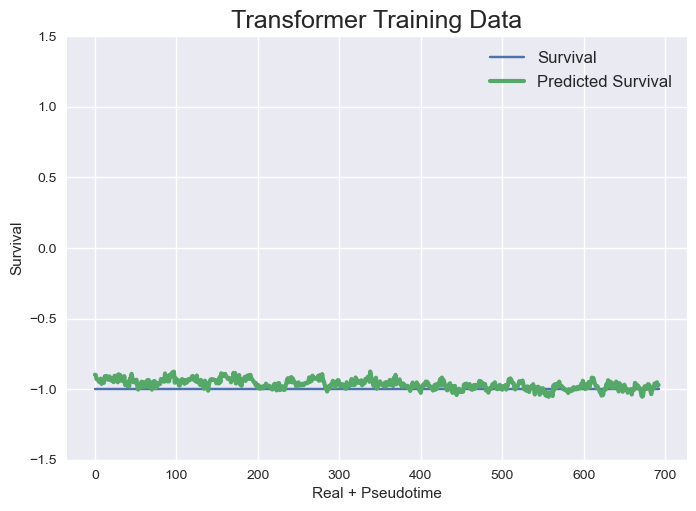

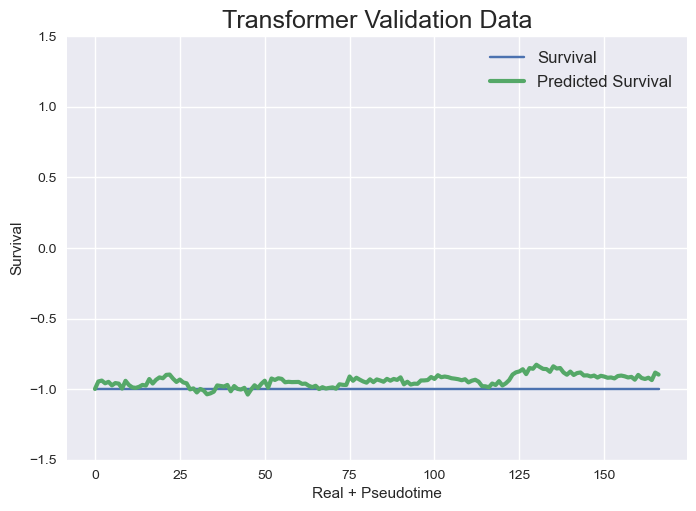

Regr Training/Val set shapes (varies depending on barcode)  (701, 1139) (175, 1139)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0000
Regr Validation Data - MSE: 0.0000


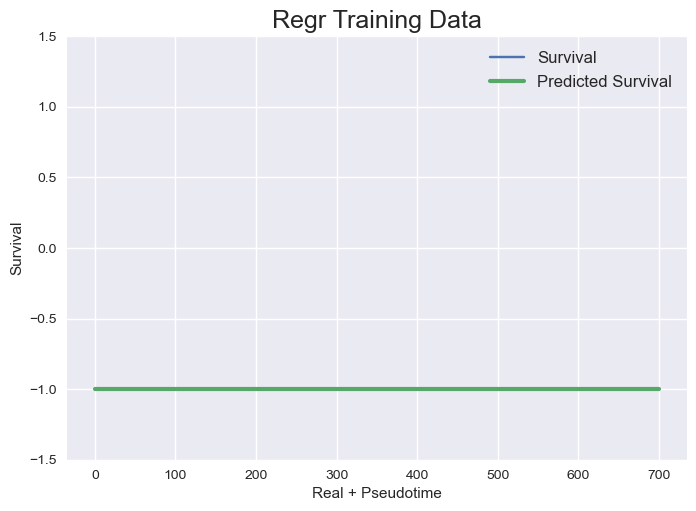

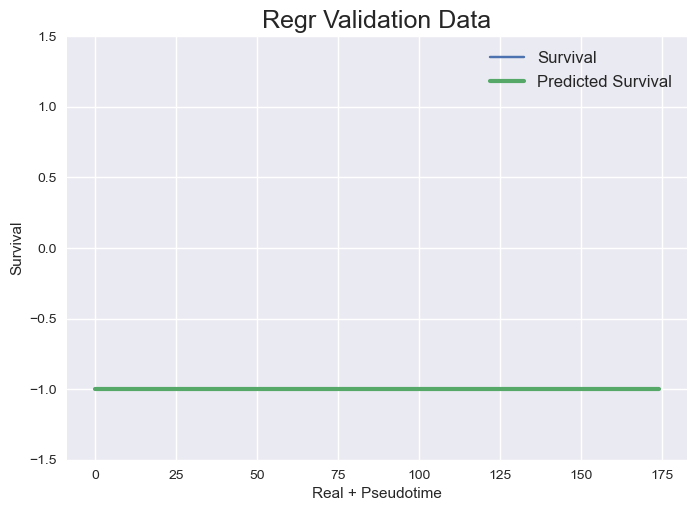

Transformer Training/Val set shapes (varies depending on barcode)  (1569, 8, 1139) (167, 8, 1139)
Epoch 1/5
50/50 [==============================] - 4s 43ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.3325 - val_mean_squared_error: 0.3325
Epoch 2/5
50/50 [==============================] - 2s 32ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.2126 - val_mean_squared_error: 0.2126
Epoch 3/5
50/50 [==============================] - 2s 31ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.2100 - val_mean_squared_error: 0.2100
Epoch 4/5
50/50 [==============================] - 2s 30ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.4094 - val_mean_squared_error: 0.4094
Epoch 5/5
50/50 [==============================] - 2s 31ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.1404 - val_mean_squared_error: 0.1404
(1569, 8, 1139) (167, 8, 1139)
6/6 [==============================] - 0s 10ms/step
 
Transformer Evalu

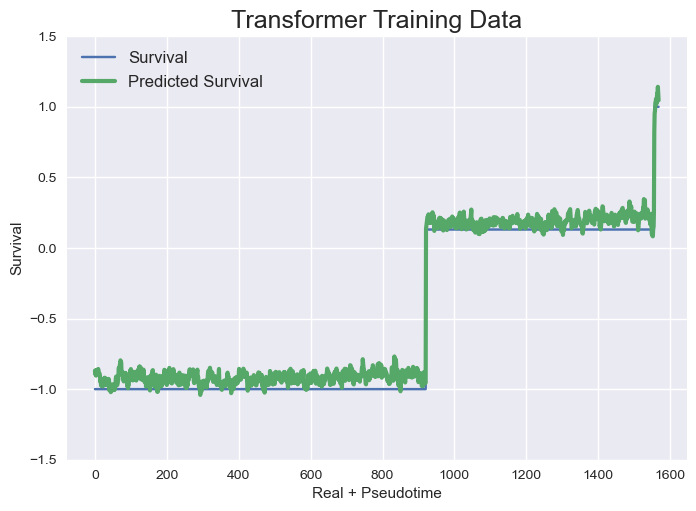

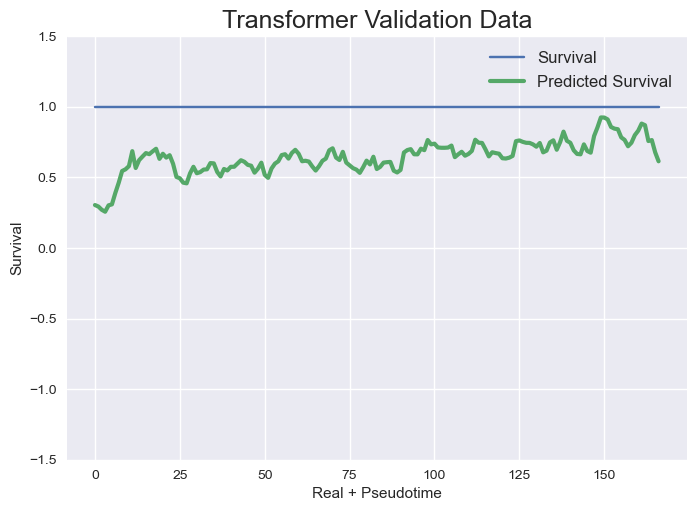

Regr Training/Val set shapes (varies depending on barcode)  (1577, 1139) (175, 1139)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0064
Regr Validation Data - MSE: 0.3060


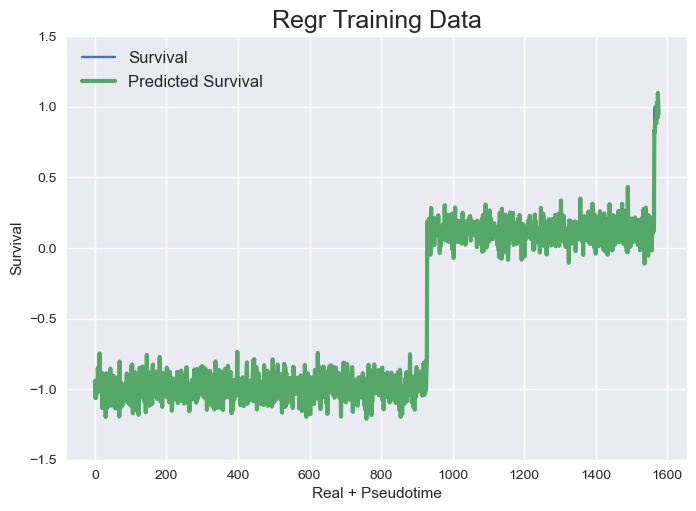

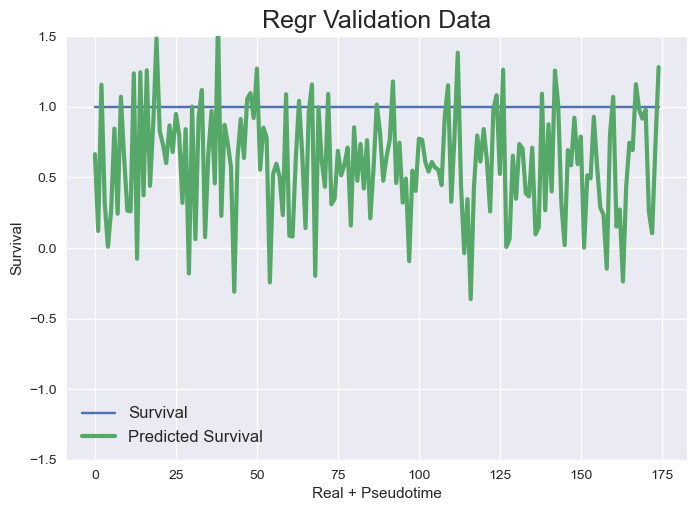

Transformer Training/Val set shapes (varies depending on barcode)  (2445, 8, 1139) (167, 8, 1139)
Epoch 1/5
77/77 [==============================] - 4s 34ms/step - loss: 0.1227 - mean_squared_error: 0.1227 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 2/5
77/77 [==============================] - 2s 31ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 3/5
77/77 [==============================] - 2s 32ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0709 - val_mean_squared_error: 0.0709
Epoch 4/5
77/77 [==============================] - 2s 31ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 5/5
77/77 [==============================] - 2s 30ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
(2445, 8, 1139) (167, 8, 1139)
6/6 [==============================] - 0s 10ms/step
 
Transformer Evalu

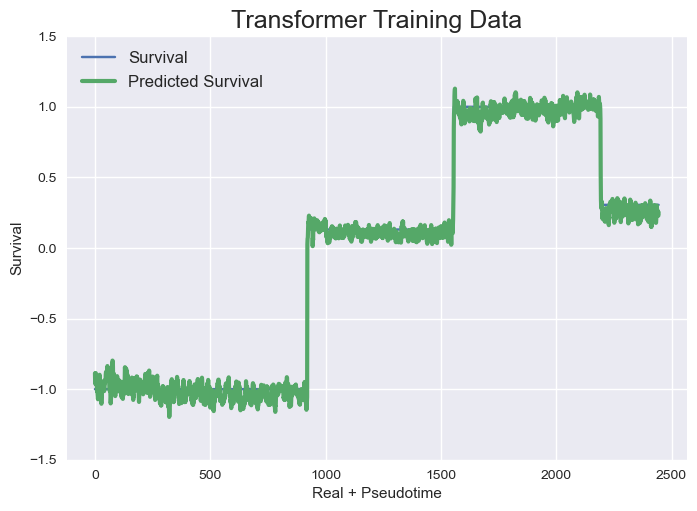

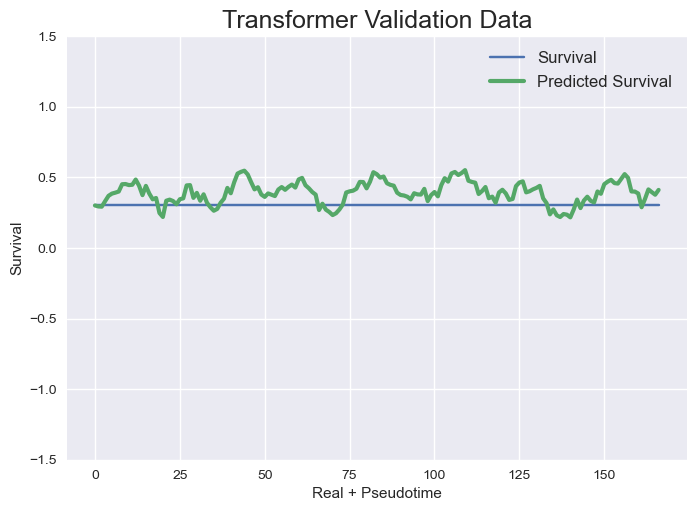

Regr Training/Val set shapes (varies depending on barcode)  (2453, 1139) (175, 1139)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0166
Regr Validation Data - MSE: 0.0732


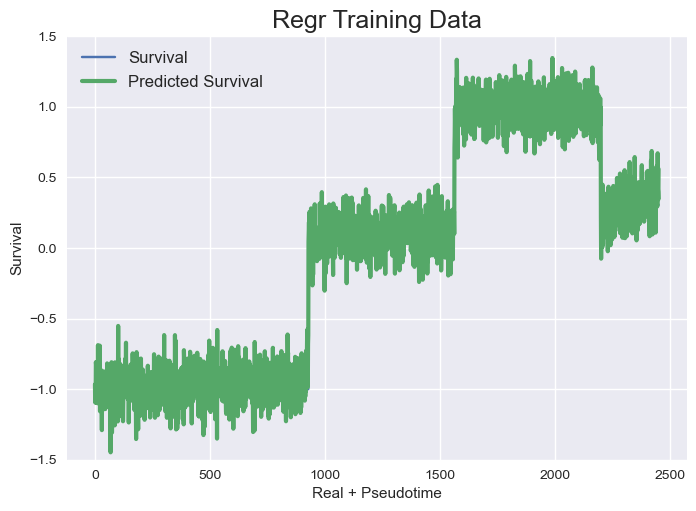

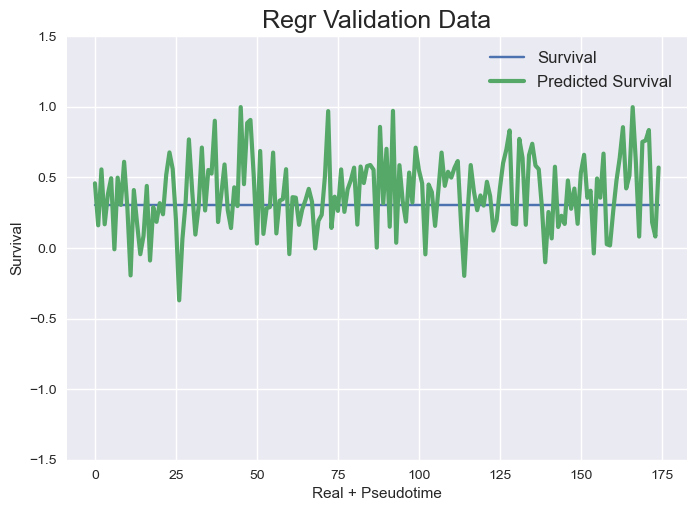

Transformer Training/Val set shapes (varies depending on barcode)  (3321, 8, 1139) (167, 8, 1139)
Epoch 1/5
104/104 [==============================] - 9s 36ms/step - loss: 0.0701 - mean_squared_error: 0.0701 - val_loss: 0.0336 - val_mean_squared_error: 0.0336
Epoch 2/5
104/104 [==============================] - 3s 30ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 3/5
104/104 [==============================] - 3s 29ms/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 4/5
104/104 [==============================] - 3s 28ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/5
104/104 [==============================] - 3s 27ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
(3321, 8, 1139) (167, 8, 1139)
6/6 [==============================] - 0s 10ms/step
 
Transfo

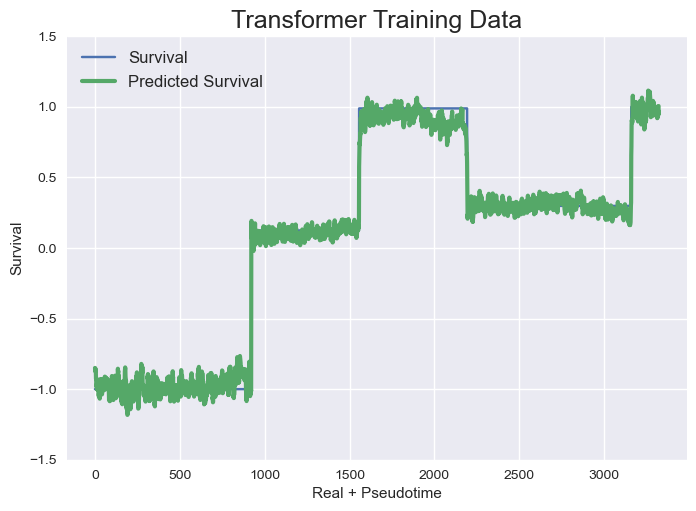

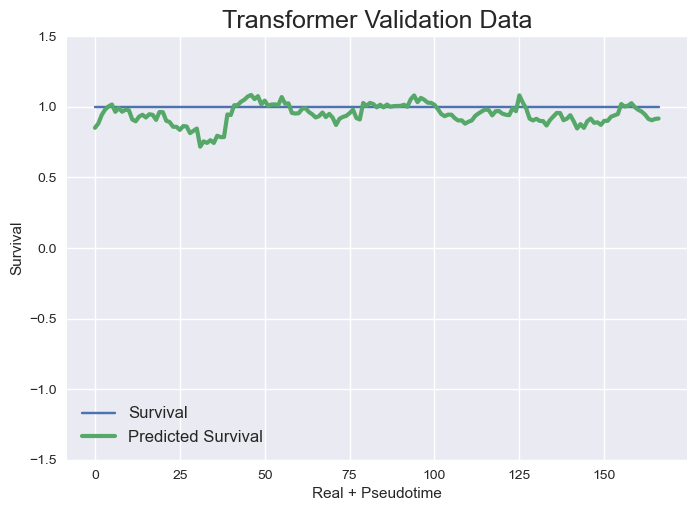

Regr Training/Val set shapes (varies depending on barcode)  (3329, 1139) (175, 1139)
 
Evaluation metrics Regr
Regr Training Data - MSE: 0.0200
Regr Validation Data - MSE: 0.0397


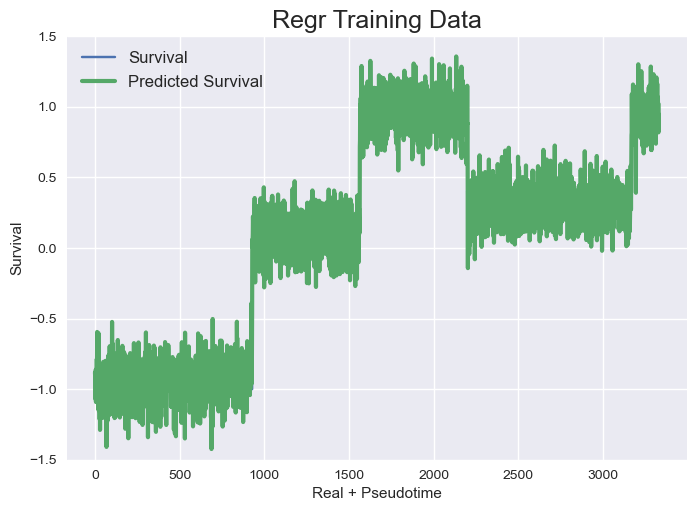

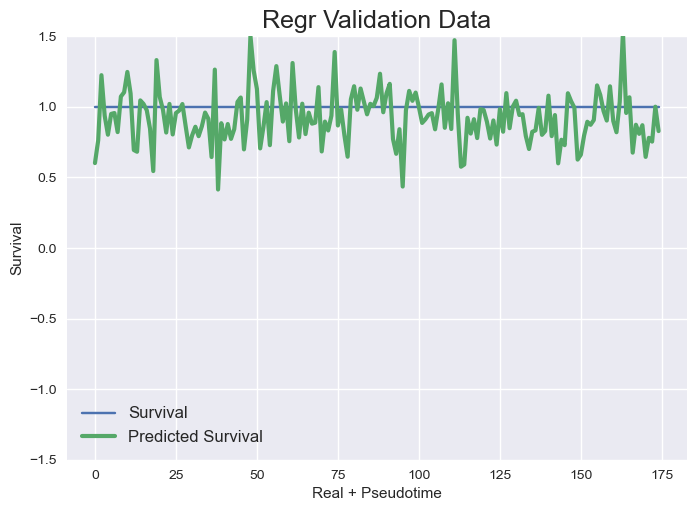

{0.25: [0.0023152872925549144, 0.0052564235367979, 0.0, 0.0], 0.5: [0.006875295632456146, 0.14041480355728708, 0.006411160227061223, 0.3059584754411151], 0.75: [0.003113703796357465, 0.01351258858825818, 0.016575760437141228, 0.07317941875638463], 1: [0.004251306380172615, 0.007883874261964541, 0.020011493475779685, 0.039681981606755665]}
{'GFPBC_libB_92196': {0.25: [0.0023152872925549144, 0.0052564235367979, 0.0, 0.0], 0.5: [0.006875295632456146, 0.14041480355728708, 0.006411160227061223, 0.3059584754411151], 0.75: [0.003113703796357465, 0.01351258858825818, 0.016575760437141228, 0.07317941875638463], 1: [0.004251306380172615, 0.007883874261964541, 0.020011493475779685, 0.039681981606755665]}}


In [21]:
# use partial_fit to train multiple times, could be different barcodes in our case
frac_val = 0.20
test_bars = ['GFPBC_libB_92196'] #, 'GFPBC_libB_90850', 'GFPBC_libB_20182'] #'GFPBC_libB_78143', 'GFPBC_libB_78143', 'GFPBC_libB_78143']
extra_var_bool = [False, False, False] # 0-realtime, 1-barcode, 2-pseudotime

intervals = [0.25, 0.5, 0.75, 1]
pct_test = frac_val/len(intervals) # comment out and use frac_val for last 20%

mse_dict = {} # structure is {barcode: {day_0: [trans_train, trans_val, regr_train, regr_val], day_n...}, barcode_n: ...}

for bar in test_bars: #new_barcodes:
    
    print('\n\n')
    print(bar)
    mse_dict[bar] = {}
    
    
    for v in intervals:
        # make the training and validation data
        X_train, y_train, X_val, y_val, COLS = transformer_train_test_split_dayiter(bar, pct_test, extra_var_bool, v)

        # build and compile model
        input_shape = X_train.shape[1:]
        model = build_model(
            input_shape,
            head_size=n_head_size, # Embedding size for attention
            num_heads=n_heads, # Number of attention heads
            ff_dim=n_ff_dim, # Hidden layer size in feed forward network inside transformer
            num_transformer_blocks=3, # six layers doesn't add or subtract much so best to keep simple
            mlp_units=[256],
            mlp_dropout=0.4, # unclear if increasing or decreasing has sizable effect
            dropout=0.14 # unclear if increasing or decreasing has sizable effect
        )
        model.compile(
            loss="mean_squared_error",
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # was 1e-4
            metrics=["mean_squared_error"],
        )
        # fit the model
        history = model.fit(X_train, y_train, 
                        batch_size=batch_size, 
                        epochs=5,
                        validation_data=(X_val, y_val)) 

        if X_val.shape[0] > 0:

            # predictions and loss
            train_mse, val_mse = plot_transformer_predictions_losses(X_train, y_train, X_val, y_val, bar, 'barmodels_combo/transformer_ptime_')

            # build multivariate regression model
            X, y, X_test, y_test = regr_train_test_split_dayiter(bar, pct_test, extra_var_bool, v)
            regr = linear_model.LinearRegression()
            regr.fit(X, y)
            regr_train_mse, regr_val_mse = plot_regr_predictions_losses(X, y, X_test, y_test, bar, 'barmodels_combo/regr_ptime_')

            # add to mse dictionary
            mse_dict[bar][v] = [train_mse, val_mse, regr_train_mse, regr_val_mse]

            # SHAP values
            #regr_SHAPvals(X_test, y_test, bar, COLS, 'barmodels_ptime7/regr_'+str(v))
            #SHAPvals(X_val, y_val, bar, COLS, 'barmodels_ptime7/transformer_'+str(v))
                

    print(mse_dict[bar])
    
print(mse_dict)

In [25]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

In [39]:
transformer = model.fit(X_train, y_train, batch_size=batch_size, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
104/104 [==============================] - 3s 31ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 2/5
104/104 [==============================] - 3s 29ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 3/5
104/104 [==============================] - 3s 27ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 4/5
104/104 [==============================] - 3s 26ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 5/5
104/104 [==============================] - 3s 25ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0073 - val_mean_squared_error: 0.0073


In [42]:
type(transformer)

keras.callbacks.History

In [41]:
from sklearn.utils.estimator_checks import check_estimator
check_estimator(transformer)

TypeError: Cannot clone object '<keras.callbacks.History object at 0x2aab7b5a02e0>' (type <class 'keras.callbacks.History'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [36]:
univariate = {}
for i in range(X_train.shape[1]):
    univariate[i] = partial_dependence(transformer.history, X_train, features=[i], kind='average')['average']

TypeError: {'loss': [0.008790208026766777], 'mean_squared_error': [0.008790208026766777]} is not an estimator instance.